# Oral Disease Classification

## Importing Required Libraries

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.1


In [3]:
# Check GPU availability
gpu_devices = tf.config.list_physical_devices('GPU')
print("GPU is", "available" if gpu_devices else "NOT available")
if gpu_devices:
    print("GPU device:", tf.test.gpu_device_name())

GPU is available
GPU device: /device:GPU:0


## Assigning Path for Dataset

In [4]:
# Paths
data_dir = '../data'
train_path = os.path.join(data_dir, 'TRAIN')
test_path = os.path.join(data_dir, 'TEST')

# Define image size to match MobileNetV2 expected input (224x224)
IMG_HEIGHT, IMG_WIDTH, channels = 224, 224, 3

## Finding Total Classes

In [5]:
# Classes: 'Caries' and 'Gingivitis'
folders = os.listdir(train_path)
folders = sorted(folders)  # Ensure a consistent order
print("Folders (Classes) found in training data:", folders)

NUM_CATEGORIES = len(folders)
print("Number of categories:", NUM_CATEGORIES)

Folders (Classes) found in training data: ['Caries', 'Gingivitis']
Number of categories: 2


## Loading the Train Dataset

In [6]:
# Load training images
image_data = []
image_labels = []
class_to_label = {class_name: idx for idx, class_name in enumerate(folders)}
print("Class to Label Mapping:", class_to_label)

for class_name in folders:
    class_folder = os.path.join(train_path, class_name)
    images = os.listdir(class_folder)
    label = class_to_label[class_name]

    for img_name in images:
        img_path = os.path.join(class_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        image = image.resize((IMG_HEIGHT, IMG_WIDTH))
        image_data.append(np.array(image))
        image_labels.append(label)

image_data = np.array(image_data)
image_labels = np.array(image_labels)
print("Image data shape:", image_data.shape)
print("Image labels shape:", image_labels.shape)

Class to Label Mapping: {'Caries': 0, 'Gingivitis': 1}
Image data shape: (1486, 224, 224, 3)
Image labels shape: (1486,)


## Visualizing the Dataset

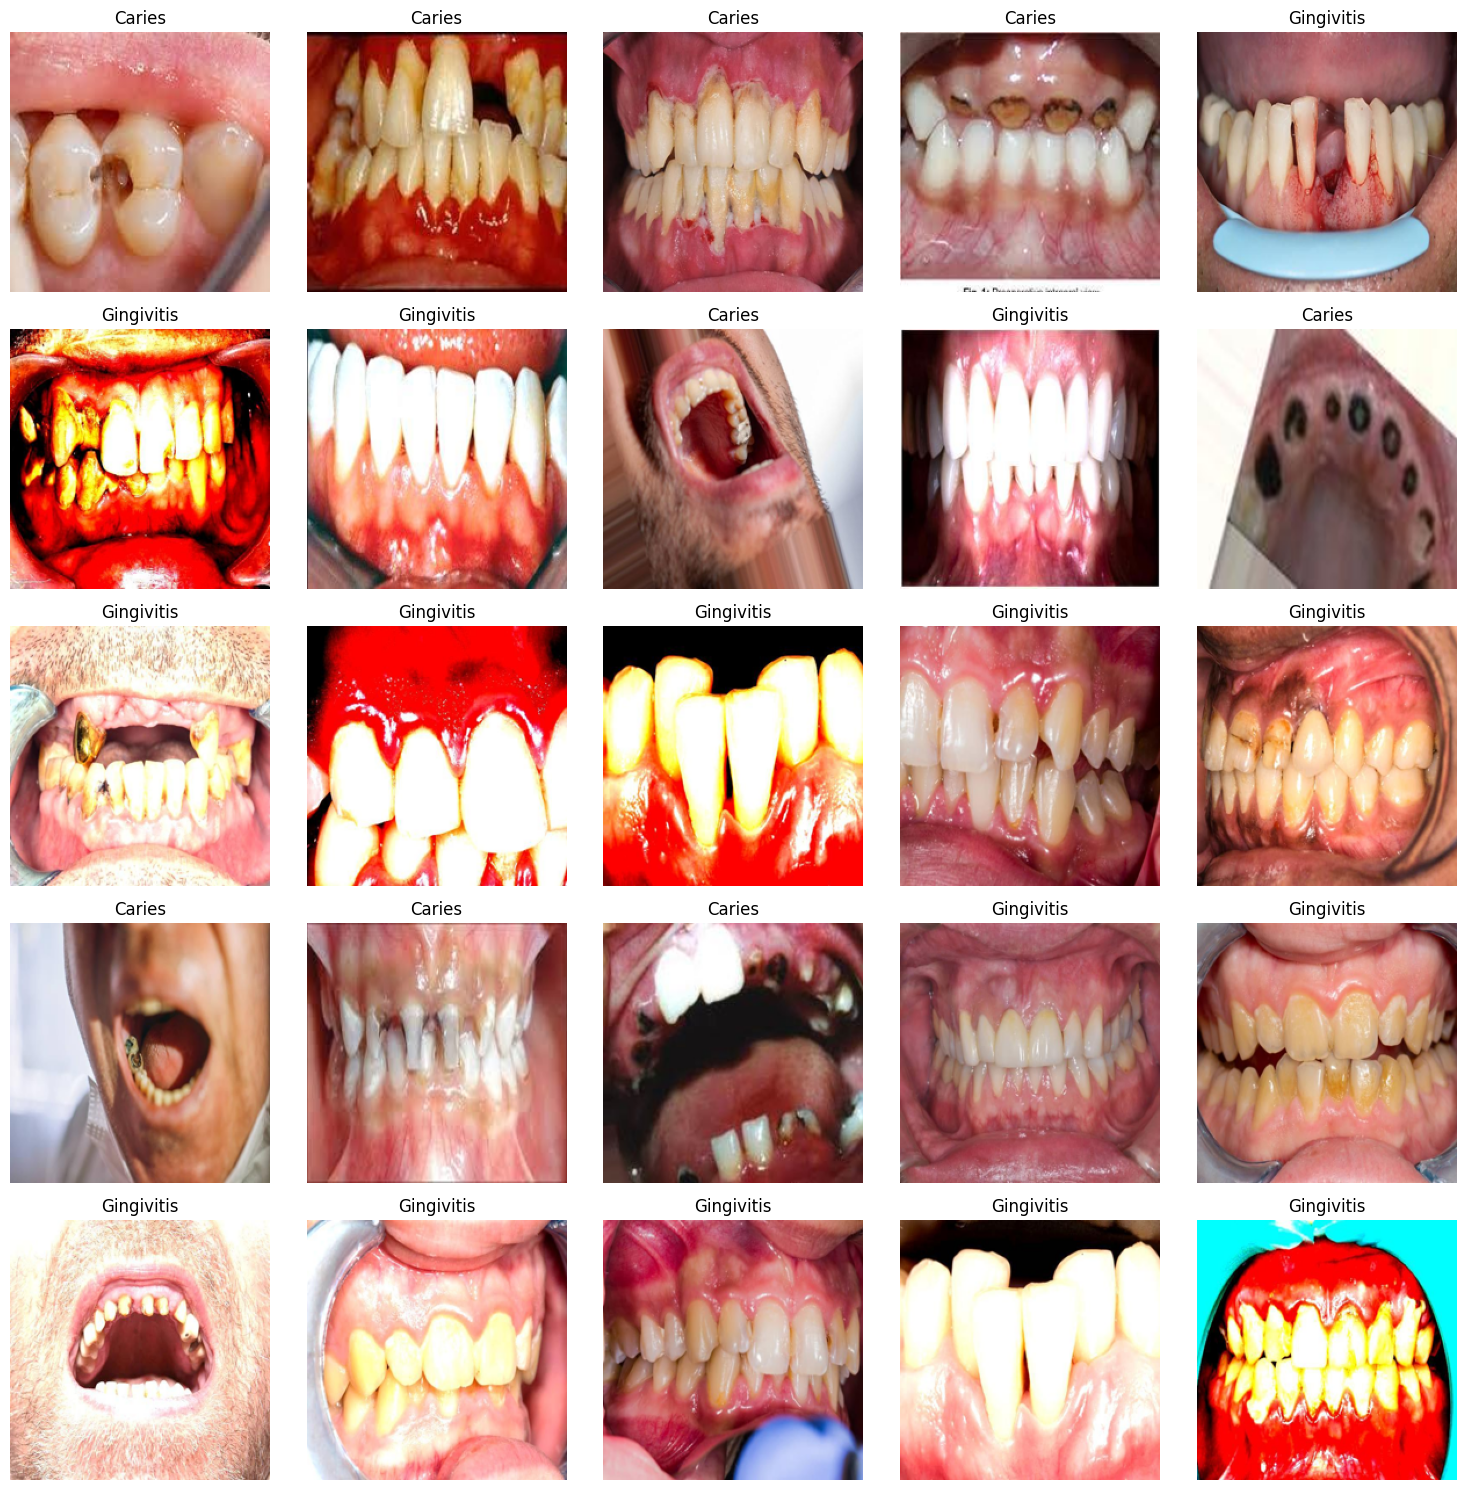

In [7]:
# Display 25 random images from the training dataset
plt.figure(figsize=(15, 15))
for i in range(1, 26):
    # Randomly select an index
    idx = random.randint(0, len(image_data) - 1)
    img = image_data[idx]
    lbl = image_labels[idx]
    class_name = folders[lbl]

    plt.subplot(5, 5, i)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Shuffling and Splitting the Training Data

In [8]:
# Shuffle and split data into train and validation sets
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  shuffle=True)

print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)
print("y_train.shape:", y_train.shape)
print("y_val.shape:", y_val.shape)

X_train.shape: (1188, 224, 224, 3)
X_val.shape: (298, 224, 224, 3)
y_train.shape: (1188,)
y_val.shape: (298,)


## Data Normalization

In [9]:
# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

## One Hot Encoding the Labels

In [10]:
# One-hot encode labels
y_train = to_categorical(y_train, NUM_CATEGORIES)
y_val = to_categorical(y_val, NUM_CATEGORIES)
print("y_train.shape:", y_train.shape)
print("y_val.shape:", y_val.shape)

y_train.shape: (1188, 2)
y_val.shape: (298, 2)


## Augmenting the data

In [11]:
# Data augmentation
aug = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

## Making the Model

In [12]:
# Use MobileNetV2 for transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, channels))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False
    
# Add custom classification layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(NUM_CATEGORIES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
# Compile the model
lr = 0.001
opt = Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

## Training the Model

In [15]:
# Train the model
history = model.fit(
    aug.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
75/75 [==============================] - 20s 189ms/step - loss: 0.5940 - accuracy: 0.8030 - val_loss: 0.2452 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 2/30
75/75 [==============================] - 11s 150ms/step - loss: 0.3751 - accuracy: 0.8603 - val_loss: 0.2108 - val_accuracy: 0.9430 - lr: 0.0010
Epoch 3/30
75/75 [==============================] - 11s 148ms/step - loss: 0.3322 - accuracy: 0.8737 - val_loss: 0.1929 - val_accuracy: 0.9497 - lr: 0.0010
Epoch 4/30
75/75 [==============================] - 11s 142ms/step - loss: 0.2969 - accuracy: 0.8838 - val_loss: 0.2085 - val_accuracy: 0.9396 - lr: 0.0010
Epoch 5/30
75/75 [==============================] - 11s 140ms/step - loss: 0.2807 - accuracy: 0.8998 - val_loss: 0.1803 - val_accuracy: 0.9396 - lr: 0.0010
Epoch 6/30
75/75 [==============================] - 11s 142ms/step - loss: 0.2790 - accuracy: 0.8956 - val_loss: 0.1732 - val_accuracy: 0.9597 - lr: 0.0010
Epoch 7/30
75/75 [==============================] - 11s 141ms/st

## Evaluating the Model

In [16]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print("Validation Accuracy:", val_accuracy)
print("Validation Loss:", val_loss)

Validation Accuracy: 0.9664429426193237
Validation Loss: 0.148405984044075


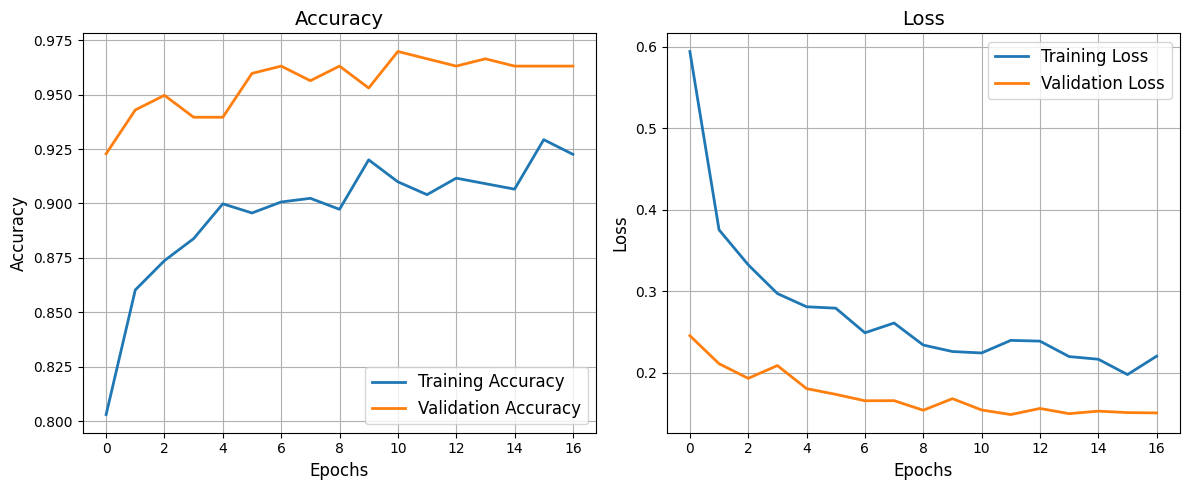

In [17]:
# Plot training history
history_df = pd.DataFrame(history.history)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history_df.index, history_df['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history_df.index, history_df['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Accuracy', fontsize=14)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.grid(True)
ax1.legend(fontsize=12)

ax2.plot(history_df.index, history_df['loss'], label='Training Loss', linewidth=2)
ax2.plot(history_df.index, history_df['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Loss', fontsize=14)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.grid(True)
ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Loading the Test Data and Running the Predictions

In [18]:
# Load test data
test_path = os.path.join(data_dir, 'TEST')
test_folders = os.listdir(test_path)
test_folders = sorted(test_folders)
print("Test folders (Classes):", test_folders)

Test folders (Classes): ['Caries', 'Gingivitis']


In [19]:
class_to_label = {class_name: idx for idx, class_name in enumerate(test_folders)}

test_data = []
test_labels = []

for class_name in test_folders:
    class_dir = os.path.join(test_path, class_name)
    label = class_to_label[class_name]
    images = os.listdir(class_dir)
    
    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            print("Error reading:", img_path)
            continue

        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Resize to model input size
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        test_data.append(np.array(resize_image))
        test_labels.append(label)

X_test = np.array(test_data, dtype='float32') / 255.0
y_test = np.array(test_labels)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (408, 224, 224, 3)
y_test shape: (408,)


In [20]:
# Predict using the trained model
pred_probabilities = model.predict(X_test, verbose=0)
predictions = np.argmax(pred_probabilities, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, predictions) * 100
print('Test Data Accuracy:', test_accuracy)

Test Data Accuracy: 95.58823529411765


## Visualizing the Confusion Matrix

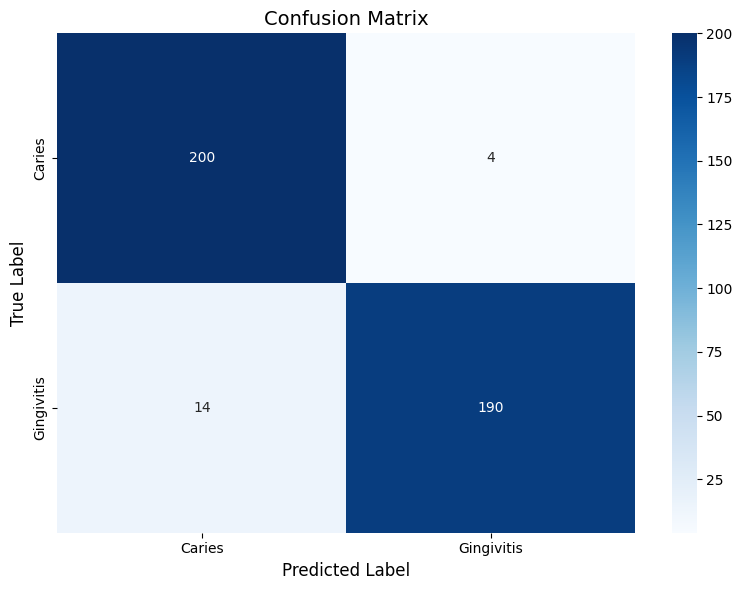

In [21]:
# Compute the confusion matrix
conf = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", xticklabels=folders, yticklabels=folders)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

## Classification Report

In [22]:
# Generate the classification report
report = classification_report(y_test, predictions, target_names=folders)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

      Caries       0.93      0.98      0.96       204
  Gingivitis       0.98      0.93      0.95       204

    accuracy                           0.96       408
   macro avg       0.96      0.96      0.96       408
weighted avg       0.96      0.96      0.96       408



## Predictions on Test Data

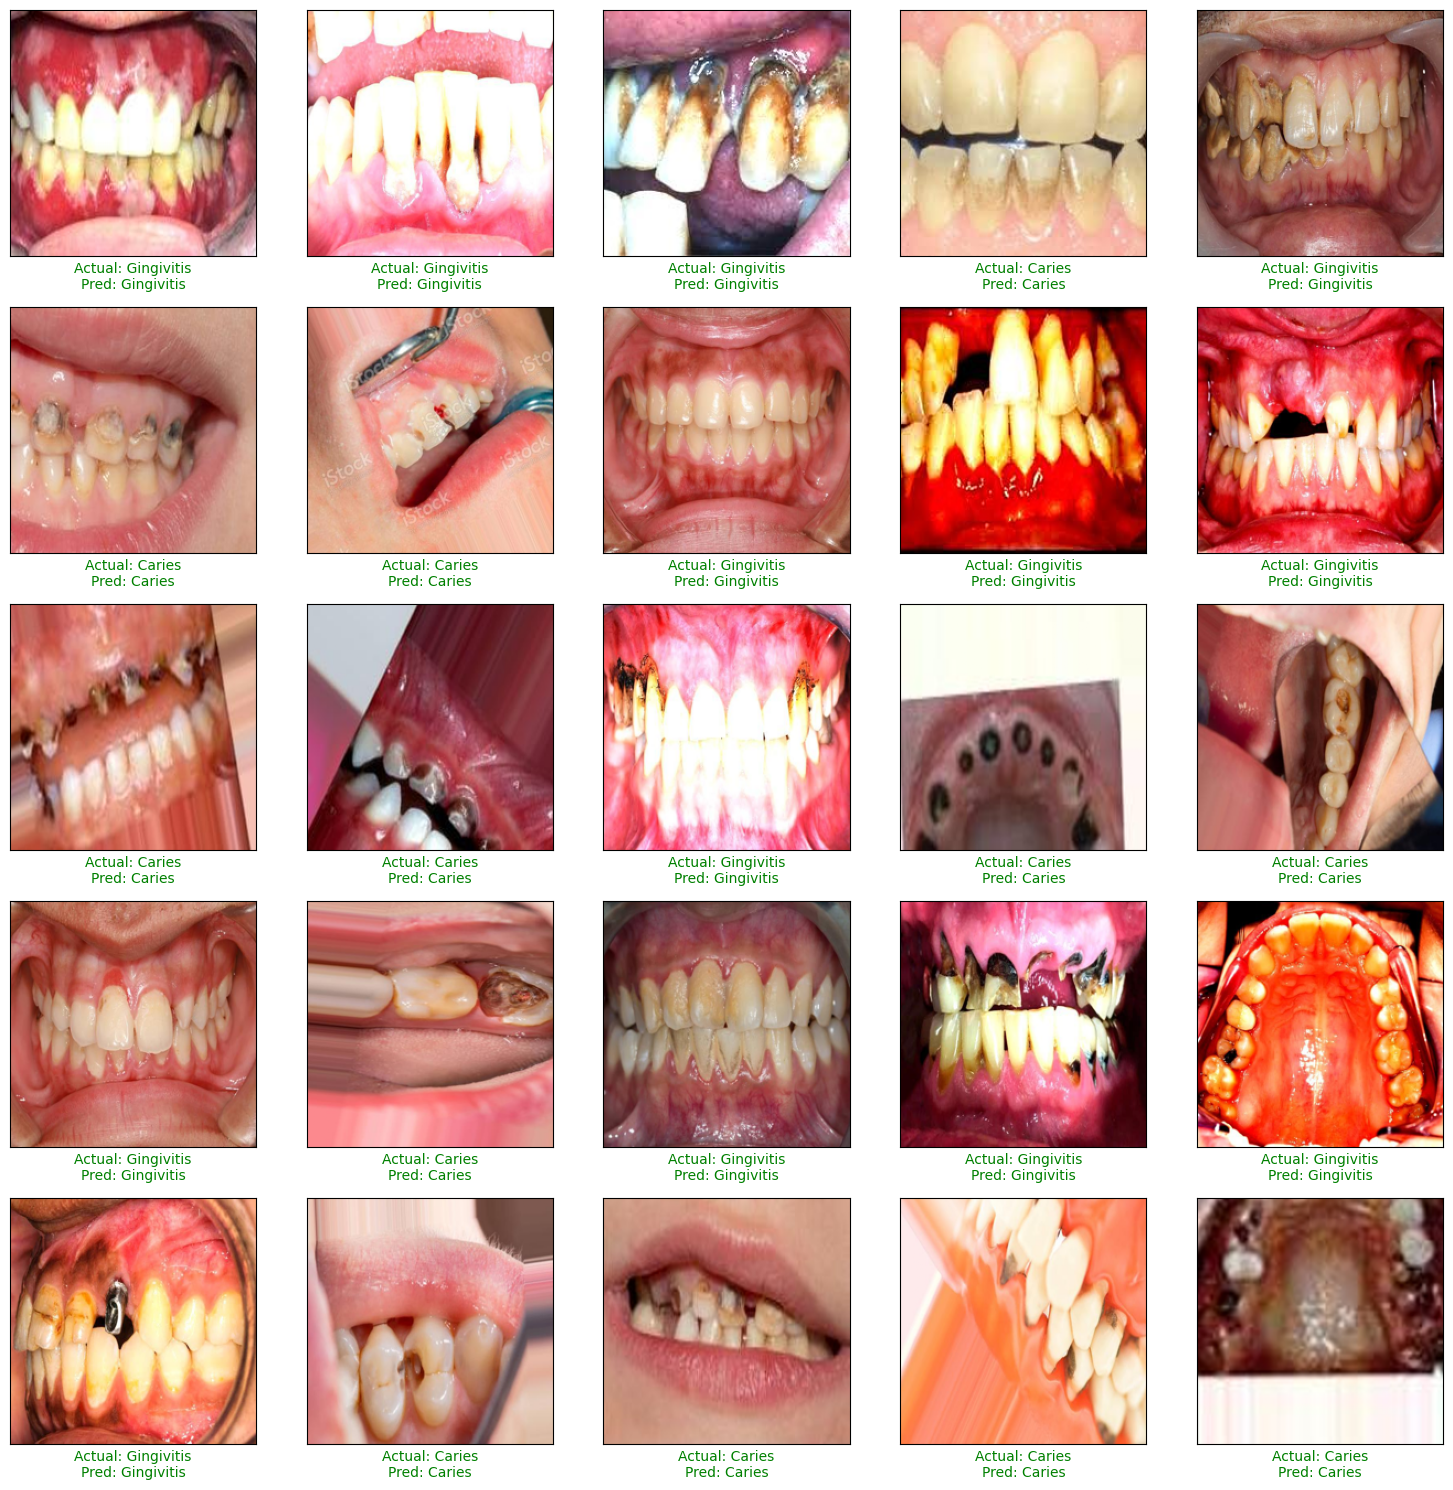

In [29]:
plt.figure(figsize=(15, 15))

# Randomly select 25 unique indices from the test dataset
random_indices = np.random.choice(len(X_test), 25, replace=False)

for i, index in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Get the predicted and actual class indices
    prediction = predictions[index]
    actual = y_test[index]

    # Map indices to class names
    actual_name = folders[actual]
    prediction_name = folders[prediction]

    # Color code the label: green if correct, red if incorrect
    col = 'g' if prediction == actual else 'r'
    plt.xlabel(f'Actual: {actual_name}\nPred: {prediction_name}', color=col)

    # Display the image
    plt.imshow(X_test[index])

plt.tight_layout()
plt.show()

## Export the Model

In [30]:
tf.saved_model.save(model, "../models/oral_disease_saved_model")

INFO:tensorflow:Assets written to: ../models/oral_disease_saved_model\assets


INFO:tensorflow:Assets written to: ../models/oral_disease_saved_model\assets


In [32]:
model.save("../models/oral_disease.h5")